# MADE Example 

pytorch implementation from https://github.com/karpathy/pytorch-made

original paper: ["Masked AutoEncoder for Density Estimation"](https://arxiv.org/abs/1502.03509) by Germain et al., 2015.

original theano code: https://github.com/mgermain/MADE

In [1]:

import sys
sys.path.append("..") # Adds higher directory to python modules path.

from made.made import MADE

import numpy as np
import torch


In [2]:
from torch.autograd import Variable

# run a quick and dirty test for the autoregressive property
D = 10
rng = np.random.RandomState(14)
x = (rng.rand(1, D) > 0.5).astype(np.float32)
print(x.shape)

configs = [
    (D, [], D, False),                 # test various hidden sizes
    (D, [200], D, False),
    (D, [200, 220], D, False),
    (D, [200, 220, 230], D, False),
    (D, [200, 220], D, True),          # natural ordering test
    (D, [200, 220], 2*D, True),       # test nout > nin
    (D, [200, 220], 3*D, False),       # test nout > nin
]

for nin, hiddens, nout, natural_ordering in configs:
    
    print("checking nin %d, hiddens %s, nout %d, natural %s" % 
            (nin, hiddens, nout, natural_ordering))
    model = MADE(nin, hiddens, nout, natural_ordering=natural_ordering)
    
    # run backpropagation for each dimension to compute what other
    # dimensions it depends on.
    res = []
    for k in range(nout):
        xtr = Variable(torch.from_numpy(x), requires_grad=True)
        xtrhat = model(xtr)
        loss = xtrhat[0,k]
        loss.backward()
        
        depends = (xtr.grad[0].numpy() != 0).astype(np.uint8)
        depends_ix = list(np.where(depends)[0])
        isok = k % nin not in depends_ix
        
        res.append((len(depends_ix), k, depends_ix, isok))
    
    # pretty print the dependencies
    res.sort()
    for nl, k, ix, isok in res:
        print("output %2d depends on inputs: %30s : %s" % (k, ix, "OK" if isok else "NOTOK"))


(1, 10)
checking nin 10, hiddens [], nout 10, natural False
output  8 depends on inputs:                             [] : OK
output  4 depends on inputs:                            [8] : OK
output  0 depends on inputs:                         [4, 8] : OK
output  7 depends on inputs:                      [0, 4, 8] : OK
output  2 depends on inputs:                   [0, 4, 7, 8] : OK
output  9 depends on inputs:                [0, 2, 4, 7, 8] : OK
output  5 depends on inputs:             [0, 2, 4, 7, 8, 9] : OK
output  6 depends on inputs:          [0, 2, 4, 5, 7, 8, 9] : OK
output  1 depends on inputs:       [0, 2, 4, 5, 6, 7, 8, 9] : OK
output  3 depends on inputs:    [0, 1, 2, 4, 5, 6, 7, 8, 9] : OK
checking nin 10, hiddens [200], nout 10, natural False
output  8 depends on inputs:                             [] : OK
output  4 depends on inputs:                            [8] : OK
output  0 depends on inputs:                         [4, 8] : OK
output  7 depends on inputs:            

## Simple Back-door scenario

## Create binary data

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from ananke.graphs import ADMG
from ananke.estimation import CausalEffect
from ananke.datasets import load_afixable_data, load_conditionally_ignorable_data, load_frontdoor_data
from ananke.estimation import AutomatedIF

# from CASTLE2 import CASTLE
from utils import heat_mat, plot_DAG, DAG_retreive_np, save_pickle, load_pickle, random_stability

                 Z            X            Y
count  5000.000000  5000.000000  5000.000000
mean      0.613400     0.641000     0.818400
std       0.487019     0.479755     0.385553
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     1.000000
50%       1.000000     1.000000     1.000000
75%       1.000000     1.000000     1.000000
max       1.000000     1.000000     1.000000
Optimization terminated successfully.
         Current function value: 0.380751
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.1964
Time:                        14:02:05   Log-Likelihood:                -1903.8
converged:         

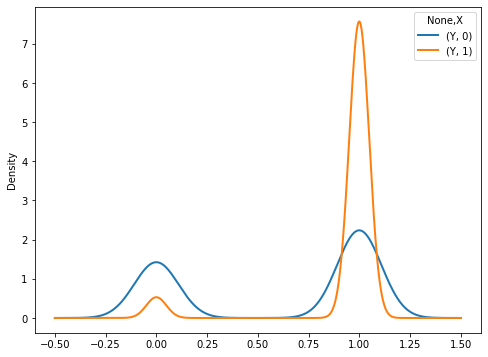

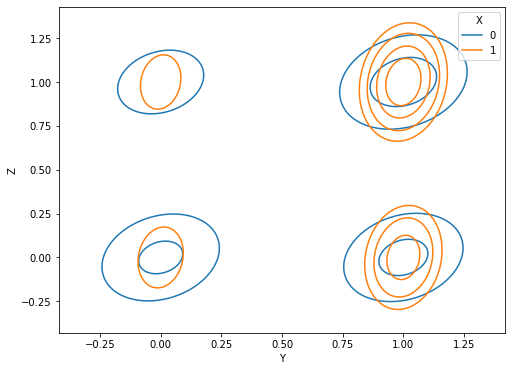

In [4]:

random_stability(123)
N = 5000

xy_coef = 2.
zy_coef = 1.

zx_coef = 1

uy_coef = 0.0

# z_transform = lambda x : np.log(x)

# z = np.random.uniform(size=N)
u = np.random.normal(size=N, loc=0., scale=1.)

# uz = np.random.normal(size=N, loc=2., scale=2.)
uz = np.random.uniform(size=N)

z = np.random.binomial(1., p=1./(1. + np.exp(-1*uz)))

x = np.random.binomial(1., p=1./(1. + np.exp(-1*zx_coef * z)))

y = np.random.binomial(1., p=1./(1. + np.exp(-1*(zy_coef * z + xy_coef * x + uy_coef* u))))

data = pd.DataFrame({'Z': z, 'X': x, 'Y': y})

print(data.describe())

import statsmodels.api as sm
mod = sm.Logit(data[['Y']], data[['X','Z']])
fii = mod.fit()
print(fii.summary())

print('Total Effect:',data[data['X']==1.].mean(axis=0)['Y'],'-',data[data['X']==0.].mean(axis=0)['Y'], '=', (data[data['X']==1.].mean(axis=0) - data[data['X']==0.].mean(axis=0))['Y'])

data_wide = data.pivot(columns = 'X', values = ['Y'])
data_wide.plot.kde(figsize = (8, 6),
                   linewidth = 2)

plt.show()

# features = data[['X','Y','Z']].values.T
# plt.scatter(features[1], features[2], alpha=0.2,
#             # s=100*features[0], 
#             c=data.X, cmap='coolwarm'
#             )
# plt.xlabel(data[['X','Y','Z']].columns[1])
# plt.ylabel(data[['X','Y','Z']].columns[2]);
# plt.show()

fig, ax = plt.subplots(figsize= (8, 6))
# ax.set(xlim=(-1.5, 4.8))
sns.kdeplot(ax=ax, data=data[['X','Y','Z']], x="Y", y="Z", hue="X",
            levels=5, thresh=.1, fill=False,
            )

plt.show()

# data[['X','Y','Z']].plot.scatter(x="Z", y="Y", c="X", cmap="rainbow", colorbar=False);



In [5]:
data.sum()/data.shape[0]

print('Total Effect P(X|Z):',data[data['Z']==1.].mean(axis=0)['X'],'-',data[data['Z']==0.].mean(axis=0)['X'], '=', (data[data['Z']==1.].mean(axis=0) - data[data['Z']==0.].mean(axis=0))['X'])

print('Total Effect P(Y|X):',data[data['X']==1.].mean(axis=0)['Y'],'-',data[data['X']==0.].mean(axis=0)['Y'], '=', (data[data['X']==1.].mean(axis=0) - data[data['X']==0.].mean(axis=0))['Y'])

print(
(data[(data['X']==1.) & (data['Z']==1.)].mean(axis=0)['Y']*data.mean(axis=0)['Z']+data[(data['X']==1.) & (data['Z']==0.)].mean(axis=0)['Y']*(1-data.mean(axis=0)['Z']))
,(data[(data['X']==0.) & (data['Z']==1.)].mean(axis=0)['Y']*data.mean(axis=0)['Z']+data[(data['X']==0.) & (data['Z']==0.)].mean(axis=0)['Y']*(1-data.mean(axis=0)['Z']))
)

Total Effect P(X|Z): 0.7257906749266384 - 0.5064666321779617 = 0.21932404274867667
Total Effect P(Y|X): 0.9344773790951638 - 0.6111420612813371 = 0.32333531781382674
0.9282896560015492 0.641619730180453


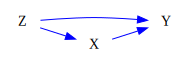

In [6]:
vertices = ['Z', 'Y', 'X']
di_edges = [('X', 'Y'), ('Z', 'Y'), ('Z', 'X')]
G = ADMG(vertices, di_edges)
G.draw(direction="LR")

In [7]:
ace_obj = CausalEffect(graph=G, treatment='X', outcome='Y')  # setting up the CausalEffect object


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 



In [8]:
ace = ace_obj.compute_effect(data, "eff-aipw") # computing the effect 
print("ace = ", ace, "\n")


ace =  1.9783076296959043 



In [9]:
data = data[['Z','X','Y']]

data

,Z,X,Y
0,0,1,1
1,1,0,1
2,1,1,1
3,0,1,1
4,1,1,1
...,...,...,...
4995,0,1,1
4996,1,1,1
4997,0,0,0
4998,1,1,1


### Derivation of back-door formula
[from this post](https://www.andrewheiss.com/blog/2021/09/07/do-calculus-backdoors/#deriving-the-backdoor-adjustment-formula-from-do-calculus-rules)


$P(Y|do(X)) = \sum_Z P(Y|do(X), Z)$ since both Y and X depend on Z, using marginalisation of pmf

$P(Y|do(X)) = \sum_Z P(Y|do(X), Z) P(Z|do(X)) $ using chain rule 

$P(Y|do(X)) = \sum_Z P(Y|X, Z) P(Z|do(X)) $ using Rule 2 of do-calculus: if a set Z of variables blocks all back-door paths from $X$ to $Y$ then, conditional on $Z$, $do(X)$ is equivalent to $see(X)$

$P(Y|do(X)) = \sum_Z P(Y|X,Z) P(Z)$ using Rule 3 of do-calculus: we can remove $do(X)$ when there are no causal paths from $X$ to $Z$

### What do we need from the network

if we structure it as an autoencoder, V will contain all the data, and we are going to predict it all at once. We need to split it, and we use MADE for this purpose. 

$P(Y,X,Z) = P(Y|X,Z)P(Z|X)P(Z)$ from chain rule

so we need 3 out neurons for 3 in neurons. We then are going to discard $P(Z|X)$ and sum over the changing $Z$ for each the possible $X$ ($X=0$ or $X=1$ in the simple binary case)

In [10]:
df = data.copy()
df['count'] = 1
df = df[df['Z']==1.]
print("Z=1 case")
pivott = pd.pivot_table(
    df, 
    values='count', 
    index=['X'], 
    columns=['Y'], 
    aggfunc=np.size, 
    fill_value=0
    )
display(pivott)
total = pivott.sum().sum()
print("P(Y,X|Z=1) =", pivott[1][1]/total)

print("P(Y|Z=1) =", pivott.sum(axis=0)[1]/total)
print("P(X|Z=1) =", pivott.sum(axis=1)[1]/total)
p_x_z1 = pivott.sum(axis=1)[1]/total

p_y_x0_z1 = (pivott[1][0]/total)/(pivott.sum(axis=1)[0]/total)
p_y_x1_z1 = (pivott[1][1]/total)/(pivott.sum(axis=1)[1]/total)
print("P(Y|X=0, Z=1) =", p_y_x0_z1)
print("P(Y|X=1, Z=1) =", p_y_x1_z1)



print("----------------------------------------------------")
df = data.copy()
df['count'] = 1
df = df[df['Z']==0.]
print("Z=0 case")
pivott = pd.pivot_table(
    df, 
    values='count', 
    index=['X'], 
    columns=['Y'], 
    aggfunc=np.size, 
    fill_value=0
    )
display(pivott)
total = pivott.sum().sum()
print("P(Y,X|Z=0) =", pivott[1][1]/total)

print("P(Y|Z=0) =", pivott.sum(axis=0)[1]/total)
print("P(X|Z=0) =", pivott.sum(axis=1)[1]/total)
p_x_z0 = pivott.sum(axis=1)[1]/total

p_y_x0_z0 = (pivott[1][0]/total)/(pivott.sum(axis=1)[0]/total)
p_y_x1_z0 = (pivott[1][1]/total)/(pivott.sum(axis=1)[1]/total)
print("P(Y|X=0,Z=0) =", p_y_x0_z0)
print("P(Y|X=1,Z=0) =", p_y_x1_z0)



print("----------------------------------------------------")
df = data.copy()
df['count'] = 1
p_z1 = df.sum(axis=0)['Z']/df.sum(axis=0)['count']
print("P(Z) =", p_z1)
def logit(x):
    return np.log(x/(1-x))


p_y_x1z = p_y_x1_z0*(1-p_z1)+p_y_x1_z1*p_z1
p_y_x0z = (p_y_x0_z0)*(1-p_z1)+(p_y_x0_z1)*p_z1

print("P(Y|do(X=1)) =", p_y_x1z)
print("P(Y|do(X=0)) =", p_y_x0z)

print("ATE =", logit(p_y_x1z) - logit(p_y_x0z))

Z=1 case


Y,0,1
X,,
0,233,608
1,94,2132


P(Y,X|Z=1) = 0.6951418324095207
P(Y|Z=1) = 0.8933811542223671
P(X|Z=1) = 0.7257906749266384
P(Y|X=0, Z=1) = 0.72294887039239
P(Y|X=1, Z=1) = 0.9577717879604671
----------------------------------------------------
Z=0 case


Y,0,1
X,,
0,465,489
1,116,863


P(Y,X|Z=0) = 0.446456285566477
P(Y|Z=0) = 0.6994309363683394
P(X|Z=0) = 0.5064666321779617
P(Y|X=0,Z=0) = 0.5125786163522013
P(Y|X=1,Z=0) = 0.881511746680286
----------------------------------------------------
P(Z) = 0.6134
P(Y|do(X=1)) = 0.9282896560015492
P(Y|do(X=0)) = 0.641619730180453
ATE = 1.9783076296862878


In [11]:
def estimate_ate_backdoor_direct(df, x, y, zs):
    """
    Estiamte the ATE of a system from a dataframe of samples `ds`
    using backdoor adjustment directly on ML estimates of probability.
    
    E[Y|do(X) = x'] = \sum_{x,y,z} y P[y|x,z] P(z|x') P(X)
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    zs: list[str]
    
    Returns 
    -------
    ATE: float
    """
    zs_unique = [tuple(a) for a in np.unique(df[zs].values, axis=0)]
    y_unique = np.unique(df[y].values, axis=0)    
    
    # P(X)
    p_x = {
        x_: np.mean(df[x] == x_)
        for x_ in (0,1)
    }

    # P(Z)
    p_z = {
        z_: np.mean(df[zs] == z_)
        for z_ in zs_unique
    }

    # P(Z|X)
    p_z_x = {
        (x_, z_): np.mean(df
            .loc[lambda df_: df_[x] == x_]
            [zs]
            .values == z_)
        for x_ in (0,1)
        for z_ in zs_unique
    }
    
    # P(Y|X,Z)
    p_y_xz = {
        (x_, y_, z_): np.mean(df
             .loc[lambda df_: df_[x] == x_]
             .loc[lambda df_: (df_[zs].values == z_).squeeze()]
             [y]
             .values == y_)
        for x_ in (0,1)
        for y_ in y_unique
        for z_ in zs_unique
    }
    
    
    # ATE
    E_y_do_x_0 = 0.0
    E_y_do_x_1 = 0.0
    p_y_do_x = 0.0
        
    for y_ in y_unique:
        for zs_ in  zs_unique:
            # for x_ in [0,1]:
            print( 'y',y_, 'z',zs_)
            print('p_y_x0z',p_y_xz[(0, y_, zs_)])
            print('p_y_x1z',p_y_xz[(1, y_, zs_)])
            print('p_z',p_z[zs_][0])

            p_y_do_x += p_y_xz[(1, y_, zs_)] * p_z[zs_][0] + p_y_xz[(0, y_, zs_)] * p_z[zs_][0]

            E_y_do_x_0 += y_ * p_y_xz[(0, y_, zs_)] * p_z[zs_][0]
            E_y_do_x_1 += y_ * p_y_xz[(1, y_, zs_)] * p_z[zs_][0]

            print('E_y_do_x_0',E_y_do_x_0)
            print('E_y_do_x_1',E_y_do_x_1)
            print('p_y_do_x', p_y_do_x)    
            print("---------------------------------")

    def logit(x):
        return np.log(x/(1-x))

    return logit(E_y_do_x_1)-logit(E_y_do_x_0)

df
# ds = fd1.sample(10000)

estimate_ate_backdoor_direct(df, "X", "Y", ["Z"])

y 0 z (0,)
p_y_x0z 0.48742138364779874
p_y_x1z 0.118488253319714
p_z 0.3866
E_y_do_x_0 0.0
E_y_do_x_1 0.0
p_y_do_x 0.23424466565164043
---------------------------------
y 0 z (1,)
p_y_x0z 0.27705112960760997
p_y_x1z 0.042228212039532795
p_z 0.6134
E_y_do_x_0 0.0
E_y_do_x_1 0.0
p_y_do_x 0.4300906138179978
---------------------------------
y 1 z (0,)
p_y_x0z 0.5125786163522013
p_y_x1z 0.881511746680286
p_z 0.3866
E_y_do_x_0 0.198162893081761
E_y_do_x_1 0.3407924412665986
p_y_do_x 0.9690459481663574
---------------------------------
y 1 z (1,)
p_y_x0z 0.72294887039239
p_y_x1z 0.9577717879604672
p_z 0.6134
E_y_do_x_0 0.6416197301804529
E_y_do_x_1 0.9282896560015491
p_y_do_x 2.0
---------------------------------


1.9783076296862865

### MADE example

In [12]:
from torch.autograd import Variable

# run a quick and dirty test for the autoregressive property
D = 3
rng = np.random.RandomState(14)
# x = (rng.rand(1, D) > 0.5).astype(np.float32)
x = data.to_numpy().astype(np.float32)
print(x.shape)

configs = [
    # (D, [], D, False),                 # test various hidden sizes
    # (D, [200], D, False),
    # (D, [200, 220], D, False),
    # (D, [200, 220, 230], D, False),
    # (D, [200, 220], D, True),          # natural ordering test
    (D, [20], D, True),       # test nout > nin
    # (D, [200, 220], 3*D, False),       # test nout > nin
]

for nin, hiddens, nout, natural_ordering in configs:
    
    print("checking nin %d, hiddens %s, nout %d, natural %s" % 
            (nin, hiddens, nout, natural_ordering))
    model = MADE(nin, hiddens, nout, natural_ordering=natural_ordering)
    
    # run backpropagation for each dimension to compute what other
    # dimensions it depends on.
    res = []
    for k in range(nout):
        xtr = Variable(torch.from_numpy(x), requires_grad=True)
        xtrhat = model(xtr)
        loss = xtrhat[0,k]
        loss.backward()
        
        depends = (xtr.grad[0].numpy() != 0).astype(np.uint8)
        depends_ix = list(np.where(depends)[0])
        isok = k % nin not in depends_ix
        
        res.append((len(depends_ix), k, depends_ix, isok))
    
    # pretty print the dependencies
    res.sort()
    for nl, k, ix, isok in res:
        print("output %s depends on%2d inputs: %30s : %s" % (data.columns[k], nl, str(list(data.columns[ix])), "OK" if isok else "NOTOK"))


(5000, 3)
checking nin 3, hiddens [20], nout 3, natural True
output Z depends on 0 inputs:                             [] : OK
output X depends on 1 inputs:                          ['Z'] : OK
output Y depends on 2 inputs:                     ['Z', 'X'] : OK


Let's extract this probabilities now

In [13]:
# sns.histplot(model(xtr)[:,0].detach().numpy())

# sns.histplot(model(xtr)[:,1].detach().numpy())
with torch.no_grad():
    print(xtr)
    print(np.unique(model(xtr)[:,0].detach().numpy()))
    print(np.unique(model(xtr)[:,1].detach().numpy()))
    print(np.unique(model(xtr)[:,2].detach().numpy()))
    # sns.histplot(model(xtr)[:,1].detach().numpy())

tensor([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 1.],
        ...,
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 1.]], requires_grad=True)
[0.5002688]
[0.43232822 0.46406007]
[0.52430993 0.532213   0.54675096 0.5538055 ]


### Train MADE

In [14]:
"""
Trains MADE on Binarized MNIST, which can be downloaded here:
https://github.com/mgermain/MADE/releases/download/ICML2015/binarized_mnist.npz
"""
import argparse

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# ------------------------------------------------------------------------------
def run_epoch(split, upto=None, samples=10, resample_every = 1):
    torch.set_grad_enabled(split=='train') # enable/disable grad for efficiency of forwarding test batches
    model.train() if split == 'train' else model.eval()
    nsamples = 1 if split == 'train' else samples
    x = xtr if split == 'train' else xte
    N,D = x.size()
    B = 100 # batch size
    nsteps = N//B if upto is None else min(N//B, upto)
    lossfs = []
    for step in range(nsteps):
        
        # fetch the next batch of data
        xb = Variable(x[step*B:step*B+B])
        
        # get the logits, potentially run the same batch a number of times, resampling each time
        xbhat = torch.zeros_like(xb)
        for s in range(nsamples):
            # perform order/connectivity-agnostic training by resampling the masks
            if step % resample_every == 0 or split == 'test': # if in test, cycle masks every time
                model.update_masks()
            # forward the model
            xbhat += model(xb)
        xbhat /= nsamples
        
        # evaluate the binary cross entropy loss
        # loss = F.binary_cross_entropy_with_logits(xbhat, xb, size_average=False) / B
        loss = F.binary_cross_entropy(xbhat, xb, size_average=False) / B
        lossf = loss.data.item()
        lossfs.append(lossf)
        
        # backward/update
        if split == 'train':
            opt.zero_grad()
            loss.backward()
            opt.step()
        
    print("%s epoch average loss: %f" % (split, np.mean(lossfs)))
# ------------------------------------------------------------------------------

In [15]:
from sklearn.model_selection import train_test_split
hidden_list = [20,20]
num_masks = 1
natural_ordering=True

# reproducibility is good
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# load the dataset
x = data.to_numpy().astype(np.float32)
print(x.shape)
xtr, xte = train_test_split(x, random_state=42, test_size=0.2)
xtr = torch.from_numpy(xtr).cuda()
xte = torch.from_numpy(xte).cuda()

# construct model and ship to GPU
# hidden_list = list(map(int, hiddens.split(',')))
model = MADE(xtr.size(1), hidden_list, xtr.size(1), num_masks=num_masks, natural_ordering=natural_ordering)
print("number of model parameters:",sum([np.prod(p.size()) for p in model.parameters()]))
model.cuda()

# set up the optimizer
opt = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

# start the training
for epoch in range(300):
    print("epoch %d" % (epoch, ))
    scheduler.step(epoch)
    run_epoch('test', upto=5) # run only a few batches for approximate test accuracy
    run_epoch('train')

print("optimization done. full test set eval:")
run_epoch('test')

(5000, 3)
number of model parameters: 563
epoch 0
test epoch average loss: 2.024564
train epoch average loss: 1.971865
epoch 1
test epoch average loss: 1.915655


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you ar

train epoch average loss: 1.855868
epoch 2
test epoch average loss: 1.807776
train epoch average loss: 1.775304
epoch 3
test epoch average loss: 1.767853
train epoch average loss: 1.753835
epoch 4
test epoch average loss: 1.759742
train epoch average loss: 1.745611
epoch 5
test epoch average loss: 1.752031
train epoch average loss: 1.736905
epoch 6
test epoch average loss: 1.742936
train epoch average loss: 1.724830
epoch 7
test epoch average loss: 1.729597
train epoch average loss: 1.708592
epoch 8
test epoch average loss: 1.715085
train epoch average loss: 1.692996
epoch 9
test epoch average loss: 1.703430
train epoch average loss: 1.681475
epoch 10
test epoch average loss: 1.696736
train epoch average loss: 1.674930
epoch 11
test epoch average loss: 1.693946
train epoch average loss: 1.671743
epoch 12
test epoch average loss: 1.692778
train epoch average loss: 1.670272
epoch 13
test epoch average loss: 1.692326
train epoch average loss: 1.669593
epoch 14
test epoch average loss: 1.6

In [16]:
model

MADE(
  (net): Sequential(
    (0): MaskedLinear(in_features=3, out_features=20, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): MaskedLinear(in_features=20, out_features=3, bias=True)
    (5): Sigmoid()
  )
)

In [17]:
# sns.histplot(model(xtr)[:,1].detach().numpy())
with torch.no_grad():
    xall = torch.from_numpy(x).cuda()
    print(xall.shape)
    print(np.unique(model(xall)[:,0].cpu().detach().numpy(),return_counts=True))
    print(np.unique(model(xall)[:,1].cpu().detach().numpy(),return_counts=True))
    print(np.unique(model(xall)[:,2].cpu().detach().numpy(),return_counts=True))

torch.Size([5000, 3])
(array([0.6150171], dtype=float32), array([5000]))
(array([0.5028529, 0.7281024], dtype=float32), array([1933, 3067]))
(array([0.5164334, 0.7277349, 0.8906818, 0.9582024], dtype=float32), array([ 954,  841,  979, 2226]))


In [18]:
df = data.copy()
df['count'] = 1
pivott = pd.pivot_table(
    df, 
    values='count', 
    index=['X'], 
    columns=['Z'], 
    aggfunc=np.size, 
    fill_value=0
    )
display(pivott)
total = pivott.sum().sum()
print("P(Z,X) =", pivott[1][1]/total)

print("P(Z) =", pivott.sum(axis=0)[1]/total)
print("P(X) =", pivott.sum(axis=1)[1]/total)

print("P(X|Z) =", (pivott[1][1]/total)/(pivott.sum(axis=0)[1]/total))

Z,0,1
X,,
0,954,841
1,979,2226


P(Z,X) = 0.4452
P(Z) = 0.6134
P(X) = 0.641
P(X|Z) = 0.7257906749266384


### Extract ACE from MADE

In [19]:
p_z = np.unique(model(xte)[:,0].cpu().detach().numpy())
p_yxz = np.unique(model(xte)[:,2].cpu().detach().numpy())
w_z = np.tile([1-p_z[0],p_z[0]], np.int(len(p_yxz)/2))
w_p = w_z*p_yxz

logit(w_p[-2:].sum())-logit(w_p[:2].sum())


2.0179166604295515

In [20]:
# Z=1 case
# P(Y,X|Z=1) = 0.6951418324095207
# P(Y|Z=1) = 0.8933811542223671
# P(X|Z=1) = 0.7257906749266384
# P(Y|X=0, Z=1) = 0.72294887039239
# P(Y|X=1, Z=1) = 0.9577717879604671
# ----------------------------------------------------
# Z=0 case
# P(Y,X|Z=0) = 0.446456285566477
# P(Y|Z=0) = 0.6994309363683394
# P(X|Z=0) = 0.5064666321779617
# P(Y|X=0,Z=0) = 0.5125786163522013
# P(Y|X=1,Z=0) = 0.881511746680286
# ----------------------------------------------------
# P(Z) = 0.6134
# P(Y|do(X=1)) = 0.9282896560015492
# P(Y|do(X=0)) = 0.641619730180453
# ATE = 1.9783076296862878

### Front Door

[from this post](http://www.degeneratestate.org/posts/2018/Sep/03/causal-inference-with-python-part-3-frontdoor-adjustment/)

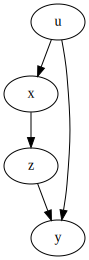

In [21]:
from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

fd0 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "x": discrete_model(["u"], {(0,): (0,1), (1,): (1,0)}),
    "z": discrete_model(["x"], {(0,): (0.95, 0.05), (1,): (0.05, 0.95)}),
    "y": discrete_model(["z", "u"], {
        (0, 0): (0.95, 0.05), 
        (0, 1): (0.95, 0.05),
        (1, 0): (0.50, 0.50), 
        (1, 1): (0.95, 0.05),
    }),
})

fd0.cgm.draw()

In [22]:
def estimate_ate_frontdoor_direct(df, x, y, zs):
    """
    Estiamte the ATE of a system from a dataframe of samples `ds`
    using frontdoor adjustment directly on ML estimates of probability.
    
    E[Y|do(X) = x'] = \sum_{x,y,z} y P[y|x,z] P(z|x') P(X)
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    zs: list[str]
    
    Returns 
    -------
    ATE: float
    """
    zs_unique = [tuple(a) for a in np.unique(df[zs].values, axis=0)]
    y_unique = np.unique(df[y].values, axis=0)    
    
    # P(X)
    p_x = {
        x_: np.mean(df[x] == x_)
        for x_ in (0,1)
    }
    
    # P(Z|X)
    p_z_x = {
        (x_, z_): np.mean(df
            .loc[lambda df_: df_[x] == x_]
            [zs]
            .values == z_)
        for x_ in (0,1)
        for z_ in zs_unique
    }
    
    # P(Y|X,Z)
    p_y_xz = {
        (x_, y_, z_): np.mean(df
             .loc[lambda df_: df_[x] == x_]
             .loc[lambda df_: (df_[zs].values == z_).squeeze()]
             [y]
             .values == y_)
        for x_ in (0,1)
        for y_ in y_unique
        for z_ in zs_unique
    }
    
    
    # ATE
    E_y_do_x_0 = 0.0
    E_y_do_x_1 = 0.0
        
    for y_ in y_unique:
        for zs_ in  zs_unique:
            for x_ in [0,1]:
                print('x:', x_,', y:', y_,', z:', zs_)
                print('p_y_xz',p_y_xz[(x_, y_, zs_)])
                print('p_z_x0',p_z_x[(0, zs_)])                
                print('p_z_x1',p_z_x[(1, zs_)])                
                print('p_x',p_x[x_])

                E_y_do_x_0 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(0, zs_)] * p_x[x_]
                E_y_do_x_1 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(1, zs_)] * p_x[x_]

                print('E_y_do_x_0',E_y_do_x_0)
                print('E_y_do_x_1',E_y_do_x_1)  

                print('------------------------------------------')  

    return E_y_do_x_1 - E_y_do_x_0

random_stability(0)
ds = fd0.sample(10000)

estimate_ate_frontdoor_direct(ds, "x", "y", ["z"])

x: 0 , y: 0.0 , z: (0.0,)
p_y_xz 0.9449287688709335
p_z_x0 0.9527957860615883
p_z_x1 0.0523301737756714
p_x 0.4936
E_y_do_x_0 0.0
E_y_do_x_1 0.0
------------------------------------------
x: 1 , y: 0.0 , z: (0.0,)
p_y_xz 0.9622641509433962
p_z_x0 0.9527957860615883
p_z_x1 0.0523301737756714
p_x 0.5064
E_y_do_x_0 0.0
E_y_do_x_1 0.0
------------------------------------------
x: 0 , y: 0.0 , z: (1.0,)
p_y_xz 0.9484978540772532
p_z_x0 0.04720421393841167
p_z_x1 0.9476698262243286
p_x 0.4936
E_y_do_x_0 0.0
E_y_do_x_1 0.0
------------------------------------------
x: 1 , y: 0.0 , z: (1.0,)
p_y_xz 0.5046884767659929
p_z_x0 0.04720421393841167
p_z_x1 0.9476698262243286
p_x 0.5064
E_y_do_x_0 0.0
E_y_do_x_1 0.0
------------------------------------------
x: 0 , y: 1.0 , z: (0.0,)
p_y_xz 0.055071231129066554
p_z_x0 0.9527957860615883
p_z_x1 0.0523301737756714
p_x 0.4936
E_y_do_x_0 0.0259
E_y_do_x_1 0.0014224994701039536
------------------------------------------
x: 1 , y: 1.0 , z: (0.0,)
p_y_xz 0.

0.20706622854775342

In [23]:
data = ds.drop('u', 1)
data

,x,z,y
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,1.0,1.0
...,...,...,...
9995,0.0,0.0,0.0
9996,1.0,1.0,1.0
9997,0.0,0.0,0.0
9998,1.0,1.0,1.0


In [24]:
from sklearn.model_selection import train_test_split
hidden_list = [20,20]
num_masks = 1
natural_ordering=True

# reproducibility is good
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# load the dataset
x = data.to_numpy().astype(np.float32)
print(x.shape)
xtr, xte = train_test_split(x, random_state=42, test_size=0.2)
xtr = torch.from_numpy(xtr).cuda()
xte = torch.from_numpy(xte).cuda()

# construct model and ship to GPU
# hidden_list = list(map(int, hiddens.split(',')))
model = MADE(xtr.size(1), hidden_list, xtr.size(1), num_masks=num_masks, natural_ordering=natural_ordering)
print("number of model parameters:",sum([np.prod(p.size()) for p in model.parameters()]))
model.cuda()

# set up the optimizer
opt = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

# start the training
for epoch in range(300):
    print("epoch %d" % (epoch, ))
    scheduler.step(epoch)
    run_epoch('test', upto=5) # run only a few batches for approximate test accuracy
    run_epoch('train')

print("optimization done. full test set eval:")
run_epoch('test')

(10000, 3)
number of model parameters: 563
epoch 0
test epoch average loss: 2.077227


/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you ar

train epoch average loss: 2.028787
epoch 1
test epoch average loss: 1.968301
train epoch average loss: 1.868502
epoch 2
test epoch average loss: 1.775160
train epoch average loss: 1.635023
epoch 3
test epoch average loss: 1.541529
train epoch average loss: 1.453594
epoch 4
test epoch average loss: 1.426779
train epoch average loss: 1.376542
epoch 5
test epoch average loss: 1.387553
train epoch average loss: 1.350028
epoch 6
test epoch average loss: 1.375276
train epoch average loss: 1.340990
epoch 7
test epoch average loss: 1.371317
train epoch average loss: 1.337636
epoch 8
test epoch average loss: 1.369920
train epoch average loss: 1.336326
epoch 9
test epoch average loss: 1.369432
train epoch average loss: 1.335655
epoch 10
test epoch average loss: 1.369189
train epoch average loss: 1.335254
epoch 11
test epoch average loss: 1.368870
train epoch average loss: 1.334944
epoch 12
test epoch average loss: 1.368645
train epoch average loss: 1.334691
epoch 13
test epoch average loss: 1.36

In [25]:
# sns.histplot(model(xtr)[:,1].detach().numpy())
with torch.no_grad():
    xall = torch.from_numpy(x).cuda()
    print(xall.shape)
    print(np.unique(model(xall)[:,0].cpu().detach().numpy(),return_counts=True))
    print(np.unique(model(xall)[:,1].cpu().detach().numpy(),return_counts=True))
    print(np.unique(model(xall)[:,2].cpu().detach().numpy(),return_counts=True))

torch.Size([10000, 3])
(array([0.5067166], dtype=float32), array([10000]))
(array([0.04528925, 0.9470839 ], dtype=float32), array([4936, 5064]))
(array([0.04982126, 0.10032789, 0.12989226, 0.4912349 ], dtype=float32), array([4703,  265,  233, 4799]))


In [26]:
df = data.copy()
df['count'] = 1
pivott = pd.pivot_table(
    df, 
    values='count', 
    index=['x'], 
    columns=['z'], 
    aggfunc=np.size, 
    fill_value=0
    )
display(pivott)
total = pivott.sum().sum()
print("P(Z,X) =", pivott[1][1]/total)

print("P(Z) =", pivott.sum(axis=0)[1]/total)
print("P(X) =", pivott.sum(axis=1)[1]/total)

print("P(X|Z) =", (pivott[1][1]/total)/(pivott.sum(axis=0)[1]/total))

z,0.0,1.0
x,,
0.0,4703,233
1.0,265,4799


P(Z,X) = 0.4799
P(Z) = 0.5032
P(X) = 0.5064
P(X|Z) = 0.9536963434022258


### Extract ACE from MADE

In [27]:
p_x = np.unique(model(xte)[:,0].cpu().detach().numpy())
p_zx = np.unique(model(xte)[:,1].cpu().detach().numpy())
p_yxz = np.unique(model(xte)[:,2].cpu().detach().numpy())
w_x = np.tile([1-p_x[0],p_x[0]], np.int(len(p_yxz)))
# w_z = np.tile(p_zx, np.int(len(p_yxz)))
w_z = np.repeat( np.array(sum(list([1-p_zx[i],p_zx[i]] for i in range(len(p_zx))),[])), 2)
# w_yxz = np.array(sum(list([1-p_yxz[i],p_yxz[i]] for i in range(len(p_yxz))),[]))
w_yxz = np.tile(p_yxz, 2)
print(w_x)
print(w_z)
print(w_yxz)

w_p = w_yxz*w_z*w_x
print(w_p)
def logit(x):
    return np.log(x/(1-x))

# logit(w_p[list(range(0,len(w_p),2))].sum()) - logit(w_p[list(range(1,len(w_p),2))].sum())
w_p[list(range(1,len(w_p),2))].sum()-w_p[list(range(0,len(w_p),2))].sum()





[0.49328339 0.50671661 0.49328339 0.50671661 0.49328339 0.50671661
 0.49328339 0.50671661]
[0.95471075 0.95471075 0.04528925 0.04528925 0.05291611 0.05291611
 0.94708389 0.94708389]
[0.04982126 0.10032789 0.12989226 0.4912349  0.04982126 0.10032789
 0.12989226 0.4912349 ]
[0.02346297 0.0485354  0.00290185 0.01127326 0.00130047 0.00269014
 0.06068316 0.23574517]


0.20989551959483776

                 Z            X            Y
count  5000.000000  5000.000000  5000.000000
mean      0.030175     0.008882     0.020647
std       1.164532     1.123748     1.318850
min      -4.143353    -3.921445    -4.218839
25%      -0.753830    -0.756479    -0.862611
50%       0.039070     0.002886     0.019388
75%       0.783219     0.777933     0.896862
max       4.300951     3.784297     4.549158
                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.305
Model:                            OLS   Adj. R-squared (uncentered):              0.304
Method:                 Least Squares   F-statistic:                              1095.
Date:                Mon, 10 Jan 2022   Prob (F-statistic):                        0.00
Time:                        14:03:46   Log-Likelihood:                         -7570.0
No. Observations:                5000   AIC:                       

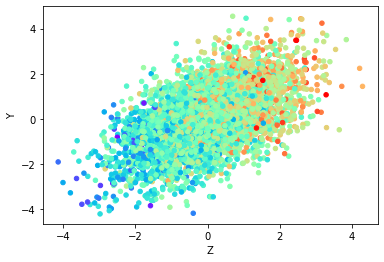

In [28]:

random_stability(123)
N = 5000

## Effects on Y
xy_coef = 0.
zy_coef = 0.5
uz_coef = 0.

# Effect on instrumental variable
xz_coef = 0.5

# Noise
uy_coef = 0. 

ux_coef = 1.


# z_transform = lambda x : np.log(x)

# z = np.random.uniform(size=N)
u = np.random.normal(size=N, loc=0., scale=1.)
ex = np.random.normal(size=N, loc=0., scale=1.)
ez = np.random.normal(size=N, loc=0., scale=1.)
ey = np.random.normal(size=N, loc=0., scale=1.)

x = 0.5 * u + ex
z = 0.5 * x + ez
y = 0.5 * u +  0.5 * z + ey

# uz = np.random.normal(size=N, loc=2., scale=2.)
# uz = np.random.uniform(size=N)

# x = np.random.binomial(1., p=1./(1. + np.exp(-1*ux_coef*uz)))

# z = np.random.binomial(1., p=1./(1. + np.exp(-1*xz_coef * x)))

# y = np.random.binomial(1., p=1./(1. + np.exp(-1*(zy_coef * z + xy_coef * x + uz_coef * uz + uy_coef* u
# ))))

data = pd.DataFrame({'Z': z, 'X': x, 'Y': y})

print(data.describe())

import statsmodels.api as sm
mod = sm.OLS(data[['Y']], data[['X','Z']])
fii = mod.fit()
print(fii.summary())


# data_wide = 
data.pivot(columns = 'X', values = ['Y'])
# data_wide.plot.kde(figsize = (8, 6),
#                    linewidth = 2)

# plt.show()

# fig, ax = plt.subplots(figsize= (8, 6))
# sns.kdeplot(ax=ax, data=data[['X','Y','Z']], x="Y", y="Z", hue="X",
#             levels=5, thresh=.1, fill=False,
#             )

# plt.show()

data[['X','Y','Z']].plot.scatter(x="Z", y="Y", c="X", cmap="rainbow", colorbar=False);
